# Getting started with TinyTimeMixer (TTM) with Exogenous Infusion 

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks with exogenous infusion. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune*: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the future values mentioned in `control_columns` as exogenous features for modelling. Search for `# exog:` keyword for important parameters to edit for exogenous infusion.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

## Installation

In [1]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git"

## Imports

In [2]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

2025-07-31 17:19:32.158802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753996772.177626  980410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753996772.183026  980410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753996772.198028  980410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753996772.198058  980410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753996772.198060  980410 computation_placer.cc:177] computation placer alr

## Important arguments

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
# target_dataset = "bike_sharing"
# DATA_ROOT_PATH = "https://raw.githubusercontent.com/blobibob/bike-sharing-dataset/main/hour.csv"

# Results dir
OUT_DIR = "../../models/ttm_tutorial_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model


## Data processing pipeline

In [4]:
from src.data.datasets.data_loader import get_loader
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad')

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00",
        "steps-0:00",
        # "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

patient = "p04"

loader = get_loader(data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True)
train_df = loader.train_data[loader.train_data["p_num"] == patient]

y_train, X_train = reduce_features(train_df)

data = pd.concat([train_df['datetime'], y_train, X_train], axis=1)
data

# _, train_period, test_period = next(loader.get_validation_day_splits(patient))
# y_day, X_day = reduce_features(train_period)
# y_night, X_night = reduce_features(test_period)

# train_period

,datetime,bg-0:00,steps-0:00,cob,carb_availability,insulin_availability,iob
61557,2025-01-01 06:05:00,6.7,0.0,0.0,0.0,0.000000,0.402800
61558,2025-01-01 06:10:00,6.6,0.0,0.0,0.0,0.003428,0.872082
61559,2025-01-01 06:15:00,6.2,0.0,0.0,0.0,0.012039,1.385682
61560,2025-01-01 06:20:00,6.0,0.0,0.0,0.0,0.024747,1.838095
61561,2025-01-01 06:25:00,5.7,0.0,0.0,0.0,0.040416,2.203691
...,...,...,...,...,...,...,...
80570,2025-03-08 06:30:00,6.1,0.0,0.0,0.0,0.484314,10.967608
80571,2025-03-08 06:35:00,6.3,0.0,0.0,0.0,0.496814,11.261682
80572,2025-03-08 06:40:00,6.4,0.0,0.0,0.0,0.512181,11.632229
80573,2025-03-08 06:45:00,6.4,0.0,0.0,0.0,0.525577,11.861722


In [5]:
# exog: Mention Exog channels in control_columns and target in target_columns
timestamp_column = "datetime"
id_columns = []

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": ["bg-0:00"], # channels for which forecasts are required
    "control_columns": [ # channels influencing the targets, with known or estimated values throughout the forecast horizon.
        "steps-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ],
}

split_params = {"train": [0, 0.5], "valid": [0.5, 0.75], "test": [0.75, 1.0]}

In [6]:
CONTEXT_HOURS = 6
HOURS_TO_PREDICT = 1

TIME_STEP_SIZE = (
    pd.to_datetime(train_df["datetime"]).iloc[1] - pd.to_datetime(train_df["datetime"]).iloc[0]
).components.minutes

# Forecasting parameters
# context_length = (60 // TIME_STEP_SIZE) * CONTEXT_HOURS
# forecast_length = (60 // TIME_STEP_SIZE) * HOURS_TO_PREDICT
context_length = 512
forecast_length = 96
print(f"time step size: {TIME_STEP_SIZE}")
print(f"forecast length: {forecast_length}")
print(f"context length: {context_length}")


tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    train_df,
    split_params,
)

time step size: 5
forecast length: 96
context length: 512


In [7]:
train_dataset[3]

{'past_values': tensor([[-0.8267,  0.0000, -0.8854, -0.9333, -1.9108, -1.7800],
         [-0.9636,  0.0000, -0.8854, -0.9333, -1.8874, -1.7505],
         [-1.1006,  0.0000, -0.8854, -0.9333, -1.8615, -1.7255],
         ...,
         [-1.3288,  0.0000, -0.7661, -0.7570, -0.9861, -0.2811],
         [-1.1919,  0.0000, -0.7756, -0.7675, -0.7834, -0.2949],
         [-0.8267,  0.0000, -0.7846, -0.7780, -0.5440, -0.3324]]),
 'future_values': tensor([[-0.3702,  0.0000, -0.7930, -0.7883, -0.4108, -0.3959],
         [ 0.0863,  0.0000, -0.8008, -0.7984, -0.3950, -0.4771],
         [ 0.4059,  0.0000, -0.8080, -0.8081, -0.4044, -0.5378],
         [ 0.7254,  0.0000, -0.8148, -0.8174, -0.4452, -0.6055],
         [ 0.8624,  0.0000, -0.8210, -0.8263, -0.5003, -0.6761],
         [ 0.9993,  0.0000, -0.8267, -0.8347, -0.5615, -0.7410],
         [ 1.1819,  0.0000, -0.8320, -0.8426, -0.6279, -0.7963],
         [ 1.4102,  0.0000, -0.8369, -0.8500, -0.6874, -0.8559],
         [ 1.5471,  0.0000, -0.8413, -0.85

## Zero-shot evaluation method

In [8]:
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"

zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
    # force_return='zeropad' # Requested context length is less than the shortest context length for TTMs: 512. Set `force_return=zeropad` to get a TTM with longer context.
)

zeroshot_model

INFO:p-980410:t-127813189366848:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r1
INFO:p-980410:t-127813189366848:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r1, revision = main.
INFO:p-980410:t-127813189366848:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [9]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

In [ ]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 1.118414282798767, 'eval_model_preparation_time': 0.0047, 'eval_runtime': 2.2599, 'eval_samples_per_second': 2062.045, 'eval_steps_per_second': 32.302}


{'eval_loss': 1.118414282798767,
 'eval_model_preparation_time': 0.0047,
 'eval_runtime': 2.2599,
 'eval_samples_per_second': 2062.045,
 'eval_steps_per_second': 32.302}

2025/07/31 17:19:48 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 0f671161dc004d83beb44d37bd0b62e3: Failed to log run data: Exception: Changing param values is not allowed. Param with key='output_dir' was already logged with value='/tmp/tmpmecokymm' for run ID='0f671161dc004d83beb44d37bd0b62e3'. Attempted logging new value 'ttm_finetuned_models/output'.
2025/07/31 17:19:48 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 0f671161dc004d83beb44d37bd0b62e3: Failed to log run data: Exception: Changing param values is not allowed. Param with key='evaluation_strategy' was already logged with value='None' for run ID='0f671161dc004d83beb44d37bd0b62e3'. Attempted logging new value 'epoch'.
2025/07/31 17:19:48 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 0f671161dc004d83beb44d37bd0b62e3: Failed to log run data: Exception: Changing param values is not allowed. Param with key='exogenous_channel_indices' was already logged with value='None' for run ID='0f6

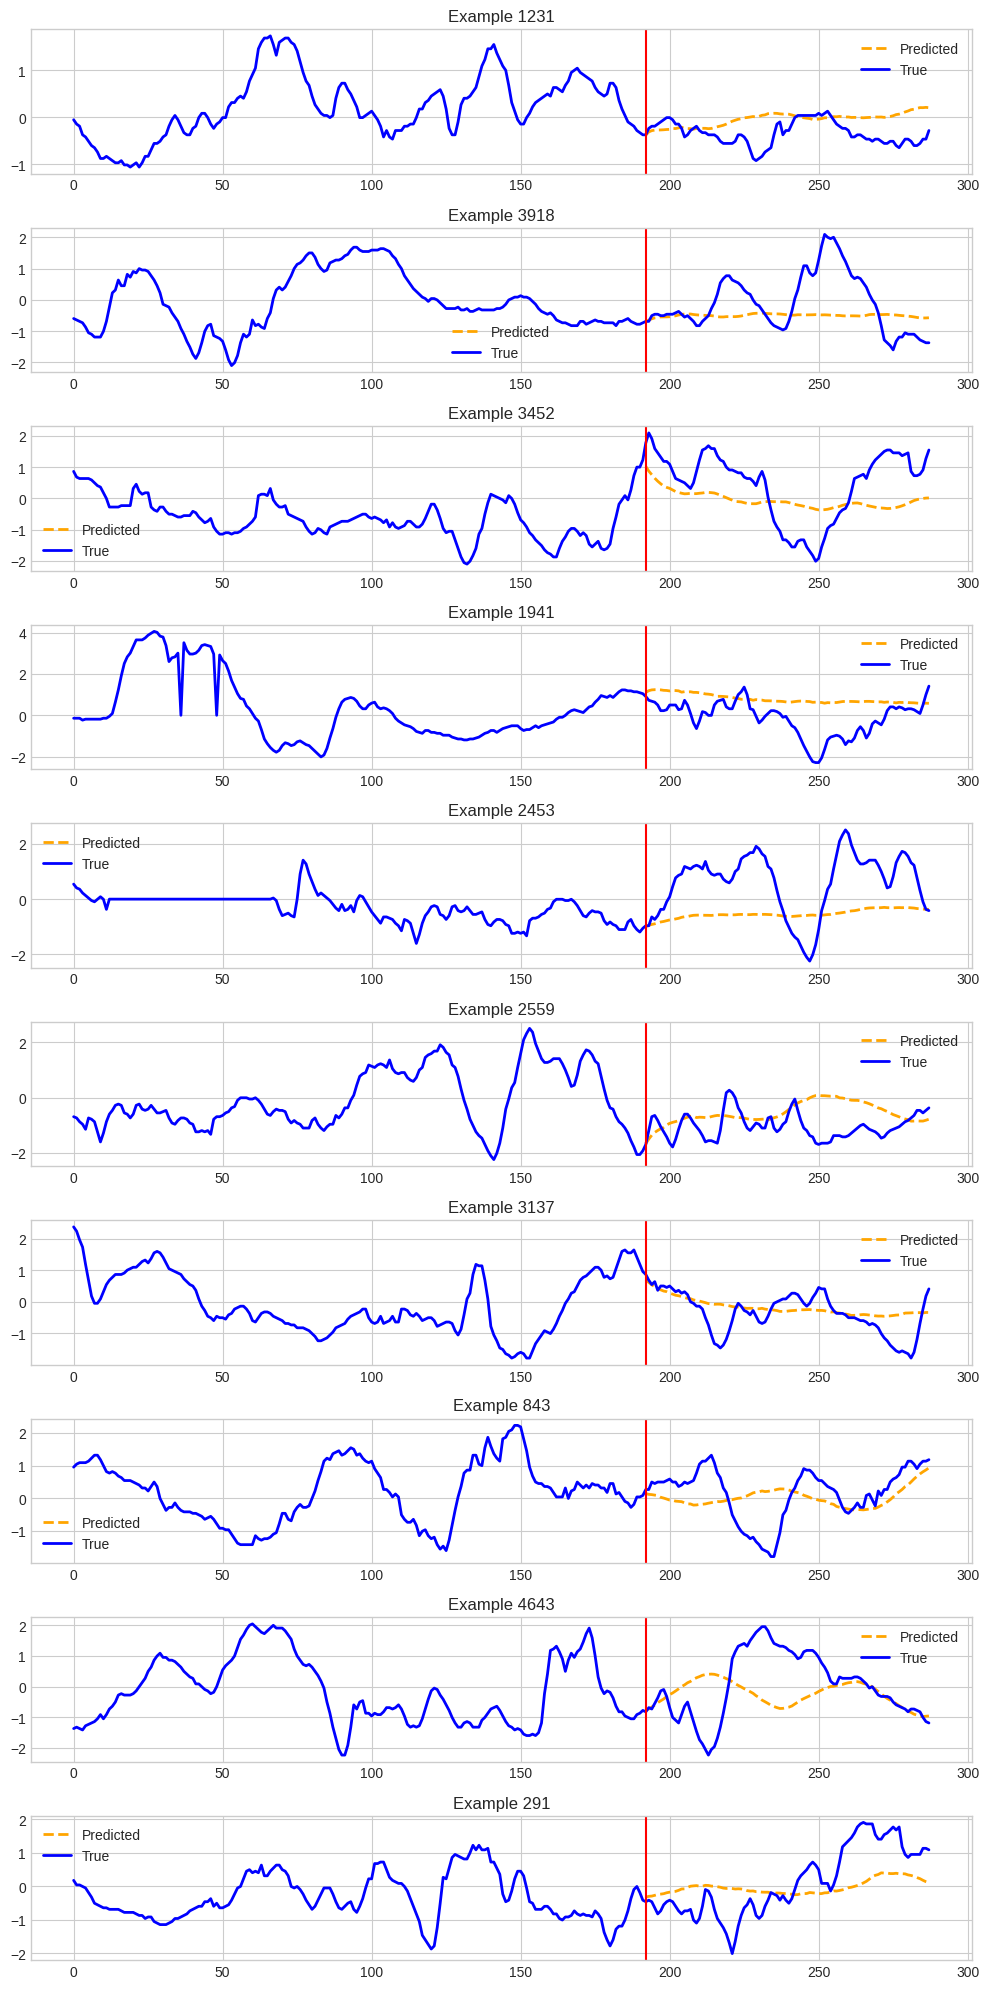

In [22]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, patient),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [12]:
finetune_forecast_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)
finetune_forecast_model

INFO:p-980410:t-127813189366848:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r1
INFO:p-980410:t-127813189366848:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r1, revision = main.
INFO:p-980410:t-127813189366848:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Frezze the TTM backbone

In [13]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 808457
Number of params after freezing the backbone 292873


### Finetune model with decoder mixing and exog fusion

In [29]:
# Important parameters


# learning_rate = 0.000298364724028334
num_epochs = 5000  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=False,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

INFO:p-980410:t-127813189366848:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-980410:t-127813189366848:lr_finder.py:optimal_lr_finder:LR Finder: Using cuda:0.
INFO:p-980410:t-127813189366848:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.0015922827933410938


OPTIMAL SUGGESTED LEARNING RATE = 0.0015922827933410938


In [30]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.0015922827933410938


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:35:23.512748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

{'loss': 0.8446, 'grad_norm': 2.1368346214294434, 'learning_rate': 6.369298803713059e-05, 'epoch': 1.0}


2025-07-31 18:36:21.618845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001381.637686 1034817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001381.643805 1034817 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001381.658659 1034817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001381.658681 1034817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001381.658698 1034817 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.0637404918670654, 'eval_runtime': 53.5573, 'eval_samples_per_second': 86.991, 'eval_steps_per_second': 1.363, 'epoch': 1.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:37:15.111146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001435.130207 1035564 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001435.136188 1035564 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.8323, 'grad_norm': 1.553878664970398, 'learning_rate': 6.369801694023811e-05, 'epoch': 2.0}


2025-07-31 18:38:13.592929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001493.612983 1036380 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001493.619057 1036380 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001493.634353 1036380 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001493.634387 1036380 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001493.634403 1036380 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.0713857412338257, 'eval_runtime': 54.82, 'eval_samples_per_second': 84.987, 'eval_steps_per_second': 1.332, 'epoch': 2.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:39:08.355279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001548.373322 1037133 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001548.379154 1037133 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.8241, 'grad_norm': 3.3057913780212402, 'learning_rate': 6.370639842090712e-05, 'epoch': 3.0}


2025-07-31 18:40:04.863490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001604.882568 1037910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001604.888181 1037910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001604.902976 1037910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001604.902999 1037910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001604.903002 1037910 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.0776755809783936, 'eval_runtime': 54.3822, 'eval_samples_per_second': 85.671, 'eval_steps_per_second': 1.342, 'epoch': 3.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:40:59.373305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001659.393746 1038667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001659.400124 1038667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.8026, 'grad_norm': 1.3500256538391113, 'learning_rate': 6.371813244237167e-05, 'epoch': 4.0}


2025-07-31 18:41:56.147566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001716.167148 1039458 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001716.173226 1039458 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001716.188542 1039458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001716.188571 1039458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001716.188574 1039458 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.0849072933197021, 'eval_runtime': 53.4295, 'eval_samples_per_second': 87.199, 'eval_steps_per_second': 1.366, 'epoch': 4.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:42:49.803055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001769.822727 1040199 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001769.828408 1040199 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7866, 'grad_norm': 2.4368984699249268, 'learning_rate': 6.373321895316035e-05, 'epoch': 5.0}


2025-07-31 18:43:46.123563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001826.141781 1041009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001826.147856 1041009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001826.162752 1041009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001826.162783 1041009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001826.162799 1041009 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.0901237726211548, 'eval_runtime': 53.6804, 'eval_samples_per_second': 86.791, 'eval_steps_per_second': 1.36, 'epoch': 5.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:44:39.950487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001879.969182 1041754 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001879.975160 1041754 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7751, 'grad_norm': 2.261725664138794, 'learning_rate': 6.375165788709497e-05, 'epoch': 6.0}


2025-07-31 18:45:37.062869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001937.081393 1042540 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001937.086745 1042540 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001937.101530 1042540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001937.101558 1042540 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001937.101561 1042540 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.0957868099212646, 'eval_runtime': 55.6495, 'eval_samples_per_second': 83.72, 'eval_steps_per_second': 1.312, 'epoch': 6.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:46:33.174406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001993.193267 1043304 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001993.199103 1043304 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7602, 'grad_norm': 3.648902654647827, 'learning_rate': 6.377344916329362e-05, 'epoch': 7.0}


2025-07-31 18:47:33.059789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002053.079177 1044171 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002053.085036 1044171 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754002053.100184 1044171 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002053.100214 1044171 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002053.100217 1044171 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.1041206121444702, 'eval_runtime': 56.7985, 'eval_samples_per_second': 82.027, 'eval_steps_per_second': 1.285, 'epoch': 7.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:48:29.921227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002109.939009 1045081 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002109.944465 1045081 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7479, 'grad_norm': 2.270789384841919, 'learning_rate': 6.379859268616783e-05, 'epoch': 8.0}


2025-07-31 18:49:31.974806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002171.993727 1046044 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002171.999107 1046044 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754002172.014370 1046044 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002172.014396 1046044 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002172.014399 1046044 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.1052193641662598, 'eval_runtime': 56.1365, 'eval_samples_per_second': 82.994, 'eval_steps_per_second': 1.3, 'epoch': 8.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:50:26.826937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002226.845260 1046823 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002226.850901 1046823 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7357, 'grad_norm': 2.4911093711853027, 'learning_rate': 6.382708834542453e-05, 'epoch': 9.0}


2025-07-31 18:51:19.852858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002279.870046 1047561 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002279.875735 1047561 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754002279.889566 1047561 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002279.889590 1047561 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002279.889611 1047561 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.1105252504348755, 'eval_runtime': 55.219, 'eval_samples_per_second': 84.373, 'eval_steps_per_second': 1.322, 'epoch': 9.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:52:15.871079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002335.890776 1048360 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002335.896916 1048360 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7214, 'grad_norm': 2.3976175785064697, 'learning_rate': 6.385893601606693e-05, 'epoch': 10.0}


2025-07-31 18:53:11.610511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002391.627964 1049185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002391.633418 1049185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754002391.647094 1049185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002391.647124 1049185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002391.647140 1049185 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.117447018623352, 'eval_runtime': 53.5532, 'eval_samples_per_second': 86.998, 'eval_steps_per_second': 1.363, 'epoch': 10.0}


/home/julia/projects/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-31 18:54:05.217342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002445.236787 1050004 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002445.242568 1050004 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting

{'loss': 0.7098, 'grad_norm': 2.157640218734741, 'learning_rate': 6.389413555839382e-05, 'epoch': 11.0}


2025-07-31 18:55:05.199889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002505.219778 1051024 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002505.225955 1051024 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754002505.241922 1051024 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002505.241946 1051024 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754002505.241962 1051024 computation_placer.cc:177] computation placer alr

{'eval_loss': 1.1290534734725952, 'eval_runtime': 55.2097, 'eval_samples_per_second': 84.387, 'eval_steps_per_second': 1.322, 'epoch': 11.0}
{'train_runtime': 1237.0637, 'train_samples_per_second': 35980.362, 'train_steps_per_second': 565.856, 'train_loss': 0.776379731413606, 'epoch': 11.0}


FileNotFoundError: [Errno 2] No such file or directory: '../../src/models/ttm_tutorial_finetuned_models/output/checkpoint-140'

In [27]:
finetune_forecast_trainer.evaluate(test_dataset)

2025-07-31 18:32:55.278285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754001175.297028 1032005 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754001175.302950 1032005 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754001175.317734 1032005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001175.317764 1032005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754001175.317780 1032005 computation_placer.cc:177] computation placer alr

{'eval_loss': 0.9711169004440308, 'eval_runtime': 58.9335, 'eval_samples_per_second': 79.072, 'eval_steps_per_second': 1.239, 'epoch': 0}


{'eval_loss': 0.9711169004440308,
 'eval_runtime': 58.9335,
 'eval_samples_per_second': 79.072,
 'eval_steps_per_second': 1.239,
 'epoch': 0}

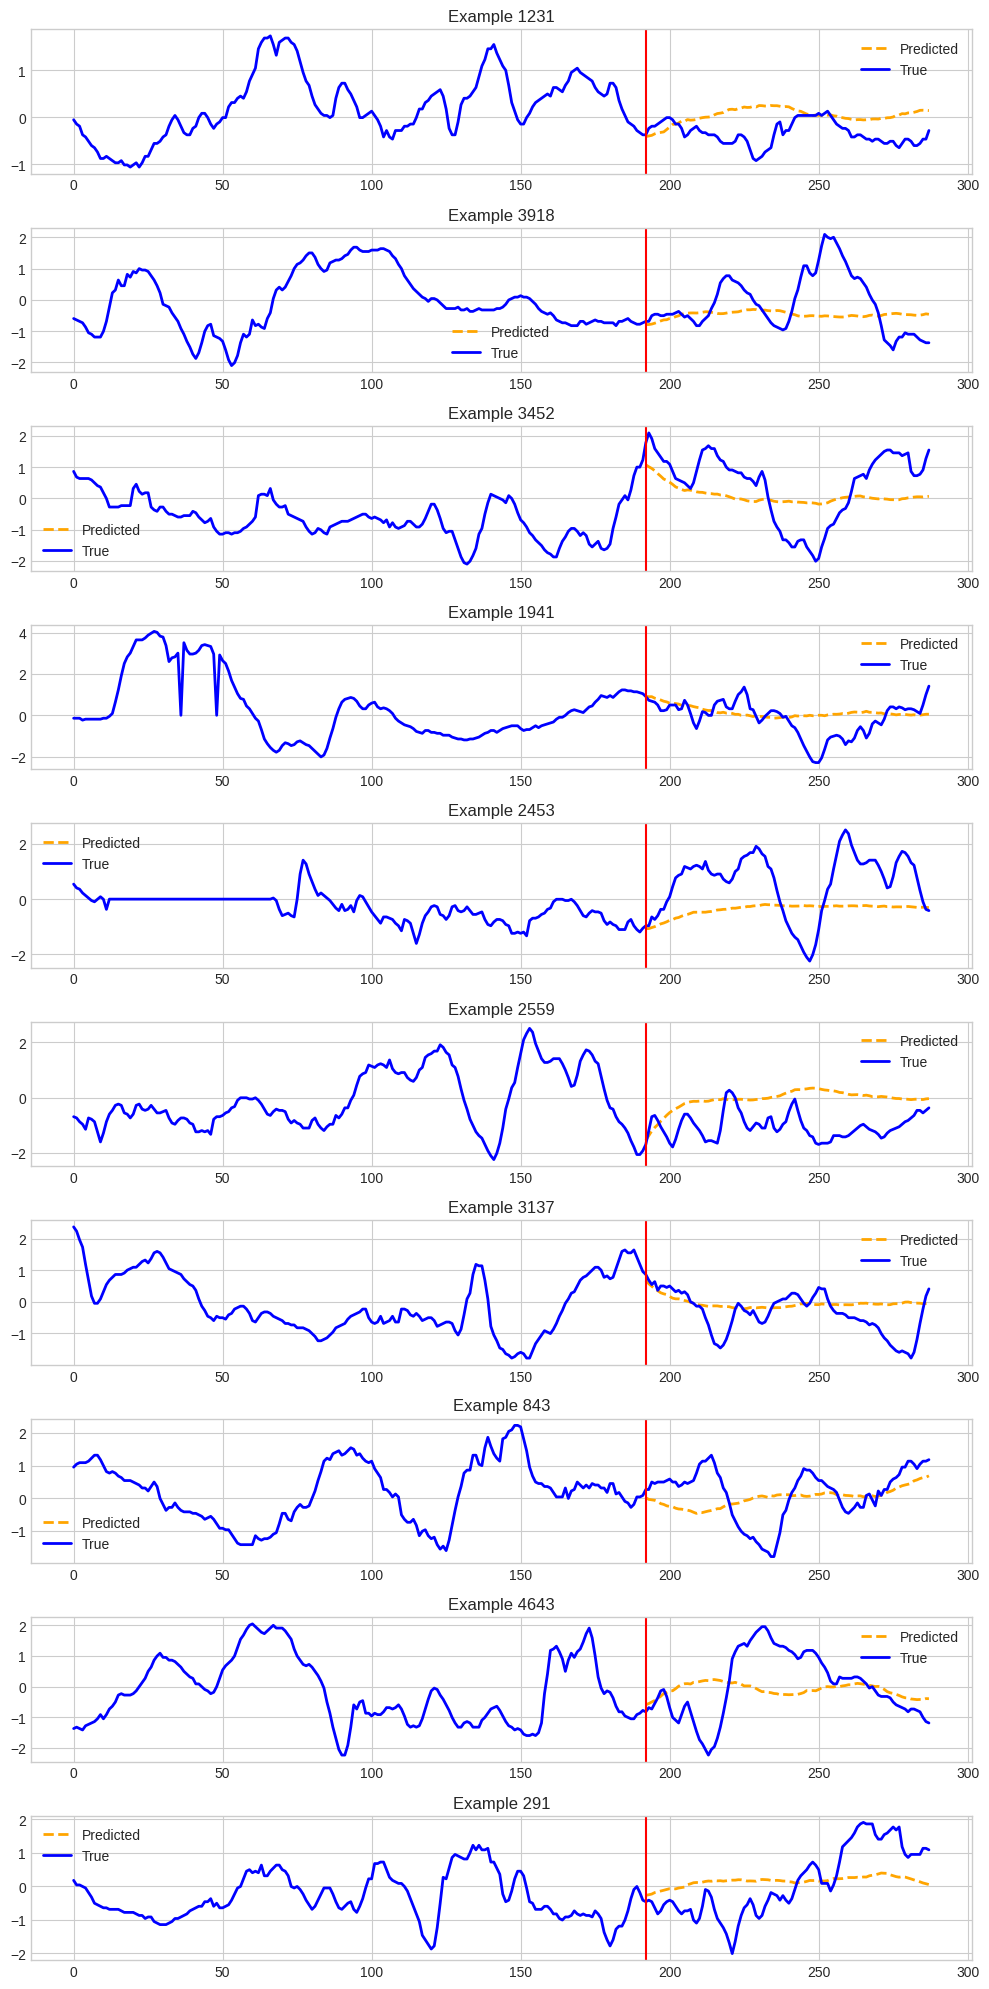

In [28]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, patient),
    plot_prefix=f"test_finetune_{num_epochs}_epochs",
    channel=0,
)